In [1]:
import torch
from matplotlib import pyplot as plt

import metrics

d:\Programs\Miniconda\envs\pytorch2\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Test parameters

In [2]:
device = "cuda"

epsilon = 0.001
activation_frequencies = torch.tensor([0.499, 0.1, 0.01, 0.001, 0.0001]) #Activation frequencies gamma to test

n_inputs = 500000 #How many inputs to simulate, more increases computational cost but reduces randomness. Should be >> 1/activation_freq for smallest
n_seeds = 1000 #How many different random seeds to average over when creating missing/extra labels

tensor([249500,  50000,   5000,    500,     50], dtype=torch.int32)


Text(0.5, 0, 'Test setting')

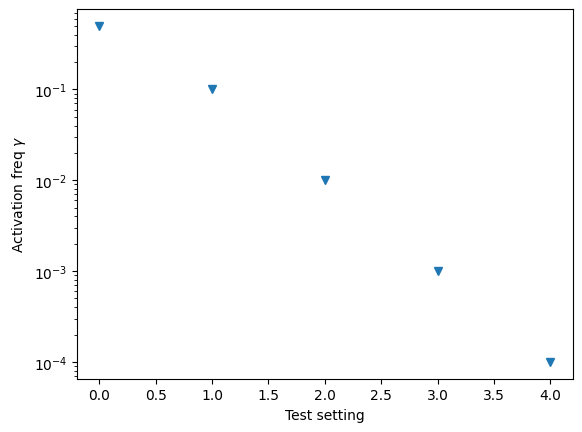

In [3]:
nums = (activation_frequencies*n_inputs).int()
concept_activations = torch.zeros(n_inputs, len(activation_frequencies), device=device)

print(nums)
for i, num in enumerate(nums):
    concept_activations[:num, i] += 1

plt.plot(torch.mean(concept_activations, dim=0).cpu(), "v")
plt.yscale("log")
plt.ylabel("Activation freq $\gamma$")
plt.xlabel("Test setting")

In [4]:
def missing_labels(concept_act):
    mask = torch.rand(concept_act.shape, device=device) > 0.5
    concepts_missing = concept_act*mask
    return concepts_missing

In [5]:
#makes sure expected number of ones for each concept is doubled in expectation
def extra_labels(concept_act):
    cutoff = torch.sum(concept_act, dim=0, keepdims=True)/(concept_act.shape[0]-torch.sum(concept_act, dim=0, keepdims=True))
    extra = torch.rand(concept_act.shape, device=device) < cutoff
    concepts_extra = torch.clamp(concept_act + extra, max=1)
    return concepts_extra

In [6]:
neuron_activations = concept_activations.clone()

correct = torch.arange(neuron_activations.shape[1])
correct = torch.nn.functional.one_hot(correct, num_classes=concept_activations.shape[1]).to(device)

## Testing different methods

In [7]:
def run_test(explanation_fn, min_val=None, max_val=None, n_samples=n_seeds):
    similarities = explanation_fn(neuron_activations, concept_activations)
    correct_sims = torch.sum(similarities*correct, dim=1)
    missing_diffs = []
    extra_diffs = []
    for _ in range(n_samples):
        concepts_missing = missing_labels(concept_activations)
        concepts_extra = extra_labels(concept_activations)
        missing_c_sims = explanation_fn(neuron_activations, concepts_missing)
        corr_miss_c_sims = torch.sum(missing_c_sims*correct, dim=1)
        extra_c_sims = explanation_fn(neuron_activations, concepts_extra)
        corr_extra_c_sims = torch.sum(extra_c_sims*correct, dim=1)
        
        if min_val==None:
            min_val = torch.min(torch.cat([similarities, missing_c_sims, extra_c_sims], dim=0))
        if max_val==None:
            max_val = torch.max(torch.cat([similarities, missing_c_sims, extra_c_sims], dim=0))

        missing_diff = (corr_miss_c_sims-correct_sims)/(max_val-min_val)
        missing_diffs.append(missing_diff)
        
        extra_diff = (corr_extra_c_sims-correct_sims)/(max_val-min_val)
        extra_diffs.append(extra_diff)

    missing_diff = torch.mean(torch.stack(missing_diffs, dim=0), dim=0)
    missing_pct = torch.mean(torch.stack(missing_diffs, dim=0)<-epsilon, dim=0, dtype=float)*100
    extra_diff = torch.mean(torch.stack(extra_diffs, dim=0), dim=0)
    extra_pct = torch.mean(torch.stack(extra_diffs, dim=0)<-epsilon, dim=0, dtype=float)*100
    for i, freq in enumerate(activation_frequencies):
        print("Activation freq:{:.4f}".format(freq))
        print("Missing labels test - Avg score diff:{:.4f}, Decrease acc:{:.2f}%".format(missing_diff[i], missing_pct[i]))
        print("Extra labels test - Avg score diff:{:.4f}, Decrease acc:{:.2f}%".format(extra_diff[i], extra_pct[i]))
    torch.cuda.empty_cache()

def fast_sims(explanation_fn, concept_acts):
    correct_ids = torch.argmax(correct, dim=1)
    correct_sims = []
    for i in range(neuron_activations.shape[1]):
        sims = explanation_fn(neuron_activations[:, i:i+1],
                                            concept_acts[:, correct_ids[i]:correct_ids[i]+1])
        correct_sims.append(sims[0,0])
    correct_sims = torch.stack(correct_sims, dim=0)
    return correct_sims

def run_test_fast(explanation_fn, min_val, max_val, n_samples=1000):
    correct_sims = fast_sims(explanation_fn, concept_activations)
    missing_diffs = []
    extra_diffs = []
    for _ in range(n_samples):
        concepts_missing = missing_labels(concept_activations)
        concepts_extra = extra_labels(concept_activations)
        corr_miss_c_sims = fast_sims(explanation_fn, concepts_missing)
        corr_extra_c_sims = fast_sims(explanation_fn, concepts_extra)

        missing_diff = (corr_miss_c_sims-correct_sims)/(max_val-min_val)
        missing_diffs.append(missing_diff)
        
        extra_diff = (corr_extra_c_sims-correct_sims)/(max_val-min_val)
        extra_diffs.append(extra_diff)
    missing_diff = torch.mean(torch.stack(missing_diffs, dim=0), dim=0)
    missing_pct = torch.mean(torch.stack(missing_diffs, dim=0)<-epsilon, dim=0, dtype=float)*100
    extra_diff = torch.mean(torch.stack(extra_diffs, dim=0), dim=0)
    extra_pct = torch.mean(torch.stack(extra_diffs, dim=0)<-epsilon, dim=0, dtype=float)*100
    for i, freq in enumerate(activation_frequencies):
        print("Activation freq:{:.4f}".format(freq))
        print("Missing labels test - Avg score diff:{:.4f}, Decrease acc:{:.2f}%".format(missing_diff[i], missing_pct[i]))
        print("Extra labels test - Avg score diff:{:.4f}, Decrease acc:{:.2f}%".format(extra_diff[i], extra_pct[i]))
    torch.cuda.empty_cache()

def run_test_alpha(explanation_fn, min_val=None, max_val=None, use_fast=False):
    """
    for fns with only an alpha parameter. Does not binarize activations as they are already binary.
    """
    if use_fast:
        run_test_fast(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=False),
                        min_val=min_val, max_val=max_val)
    else:
        run_test(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=False),
                        min_val=min_val, max_val=max_val)

def run_test_alpha_lam(explanation_fn, min_val=None, max_val=None):
    """
    Note: uses lmabda=1 for evaluations
    """
    run_test(explanation_fn=lambda x, y: explanation_fn(x, y, alpha=False, lam=1),
                       min_val=min_val, max_val=max_val)

### Recall

In [8]:
run_test_alpha(metrics.recall, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0000, Decrease acc:0.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0000, Decrease acc:0.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0000, Decrease acc:0.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.4992, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0000, Decrease acc:0.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.5024, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0000, Decrease acc:0.00%


### Precision

In [9]:
run_test_alpha(metrics.precision, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.4999, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.5001, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.4974, Decrease acc:100.00%


### F1-score

In [10]:
run_test_alpha(metrics.f1_score, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.3333, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3333, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.3333, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3333, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.3332, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3334, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.3337, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3331, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.3373, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3295, Decrease acc:100.00%


### IoU

In [11]:
run_test_alpha(metrics.iou, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.5001, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4999, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.4999, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4994, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.5012, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4963, Decrease acc:100.00%


### Accuracy

In [12]:
run_test_alpha(metrics.accuracy, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2495, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4990, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0050, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0100, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0005, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.0010, Decrease acc:50.30%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.0001, Decrease acc:0.00%


### Balanced accuracy

In [13]:
run_test_alpha(metrics.balanced_accuracy, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4980, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0556, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.2501, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0050, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0005, Decrease acc:0.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.2499, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0000, Decrease acc:0.00%


### Inverse Balanced Accuracy

In [14]:
run_test_alpha(metrics.inverse_balanced_accuracy, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.1662, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0263, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0025, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0002, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.2497, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.2488, Decrease acc:100.00%


### AUC

In [15]:
run_test_alpha(metrics.auc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.7562, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0844, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.2501, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0077, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.2498, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0008, Decrease acc:0.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.2503, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0001, Decrease acc:0.00%


### Inverse AUC (Classification)

In [16]:
run_test_fast(metrics.inverse_auc, min_val=0, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.1662, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2498, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0263, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0025, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.2500, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0002, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.2497, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.2491, Decrease acc:100.00%


### Correlation

In [17]:
run_test_fast(metrics.correlation, min_val=-1, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2111, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4776, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.1559, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1667, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1474, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1482, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1470, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1466, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1487, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1460, Decrease acc:100.00%


### Correlation top-and-random

In [18]:
run_test_fast(metrics.correlation_top_and_random_binary, min_val=-1, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.4965, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4926, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.4894, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0289, Decrease acc:93.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.4649, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0024, Decrease acc:20.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.3927, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0003, Decrease acc:2.30%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.2459, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0000, Decrease acc:0.20%


### Spearman Correlation

In [19]:
run_test_fast(metrics.spearman_correlation, min_val=-1, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2000, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5671, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0676, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0228, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0079, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0007, Decrease acc:31.40%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0011, Decrease acc:55.60%
Extra labels test - Avg score diff:-0.0004, Decrease acc:19.10%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0004, Decrease acc:19.80%
Extra labels test - Avg score diff:-0.0003, Decrease acc:19.00%


### Spearman Correlation top-and-random

In [20]:
run_test_fast(metrics.spearman_correlation_top_and_random_binary, min_val=-1, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.1020, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0012, Decrease acc:58.60%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0996, Decrease acc:100.00%
Extra labels test - Avg score diff:0.0013, Decrease acc:14.20%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1099, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0067, Decrease acc:81.30%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1464, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0265, Decrease acc:92.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1431, Decrease acc:99.80%
Extra labels test - Avg score diff:0.0535, Decrease acc:0.40%


### Cosine

In [21]:
run_test_fast(metrics.cos_sim, min_val=-1, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.1465, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1464, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.1464, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1464, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1464, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1465, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1466, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1465, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1490, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1464, Decrease acc:100.00%


### WPMI

In [22]:
run_test_alpha_lam(metrics.wpmi)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.3676, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0299, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.3675, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0299, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.3678, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0299, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.3673, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0299, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.3700, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0298, Decrease acc:100.00%


### MAD (Mean Activation Difference)

In [23]:
run_test(metrics.mad)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.3325, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0526, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0050, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5002, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0005, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.4999, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.4984, Decrease acc:100.00%


## AUPRC

In [24]:
run_test_alpha(metrics.auprc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2505, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.4500, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.4953, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.4999, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.5002, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.5004, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4981, Decrease acc:100.00%


## Inverse AUPRC

In [25]:
run_test_fast(metrics.inverse_auprc, min_val=0, max_val=1)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.5000, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0010, Decrease acc:52.30%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.5001, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.4996, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4898, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.4997, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4985, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.5015, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4971, Decrease acc:100.00%


# Appendix: Combination Metrics

In [26]:
run_test_alpha(metrics.combined_auc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2104, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.6320, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.1527, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1754, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1438, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1458, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1437, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1428, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1427, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1430, Decrease acc:100.00%


In [27]:
run_test_alpha(metrics.combined_balanced_acc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.2103, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3986, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.1527, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1639, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1438, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1447, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1430, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1433, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1438, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1426, Decrease acc:100.00%


In [28]:
run_test_alpha(metrics.recall_auc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.4000, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.6080, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.3999, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0440, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.3996, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0038, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.4003, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0004, Decrease acc:0.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.4033, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.0000, Decrease acc:0.00%


In [29]:
run_test_alpha(metrics.recall_inv_auc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.3749, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1428, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.3393, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1428, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.3342, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1428, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.3339, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1427, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.3330, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.1425, Decrease acc:100.00%


In [30]:
run_test_alpha(metrics.precision_bal_acc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.1429, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4990, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.1428, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3462, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.1430, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3346, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.1433, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3333, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.1439, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.3301, Decrease acc:100.00%


In [31]:
run_test_alpha(metrics.precision_inverse_bal_acc, min_val=0, max_val=1, use_fast=True)

Activation freq:0.4990
Missing labels test - Avg score diff:-0.0906, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4000, Decrease acc:100.00%
Activation freq:0.1000
Missing labels test - Avg score diff:-0.0133, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4000, Decrease acc:100.00%
Activation freq:0.0100
Missing labels test - Avg score diff:-0.0013, Decrease acc:100.00%
Extra labels test - Avg score diff:-0.4001, Decrease acc:100.00%
Activation freq:0.0010
Missing labels test - Avg score diff:-0.0001, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.3998, Decrease acc:100.00%
Activation freq:0.0001
Missing labels test - Avg score diff:-0.0000, Decrease acc:0.00%
Extra labels test - Avg score diff:-0.3968, Decrease acc:100.00%
